Warning message:
"package 'genlasso' was built under R version 3.4.2"Loading required package: MASS
Warning message:
"package 'MASS' was built under R version 3.4.3"Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.4.3"Loading required package: igraph
Warning message:
"package 'igraph' was built under R version 3.4.2"
Attaching package: 'igraph'

The following objects are masked from 'package:stats':

    decompose, spectrum

The following object is masked from 'package:base':

    union

Warning message:
"package 'dplyr' was built under R version 3.4.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:igraph':

    as_data_frame, groups, union

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'tidyr' was bu

[1] TRUE
[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[1] TRUE TRUE TRUE TRUE TRUE


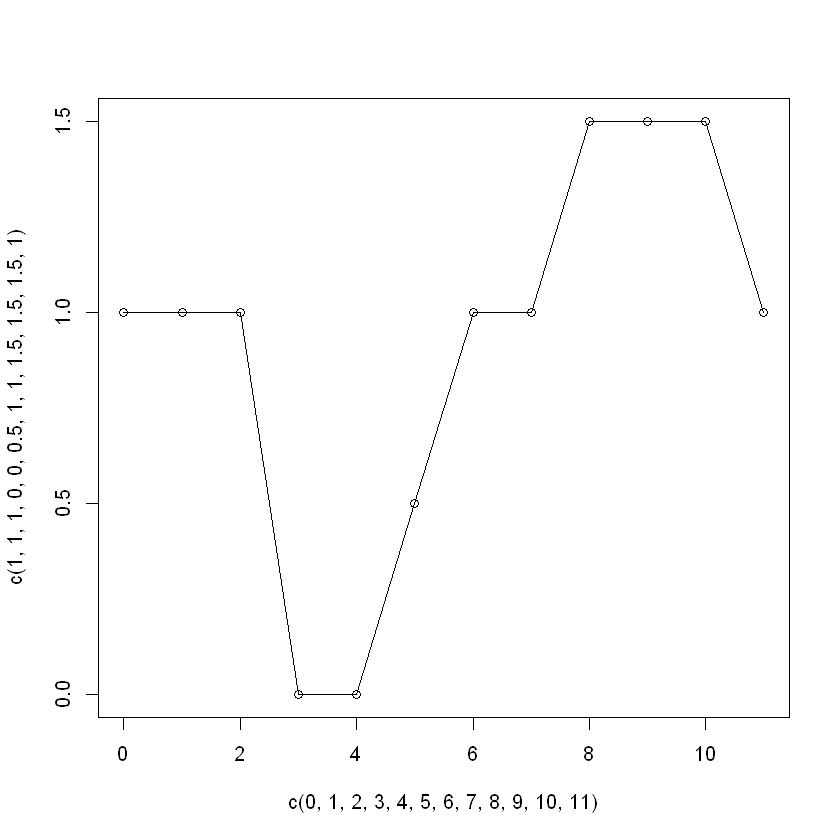

In [1]:
library(genlasso)
library(dplyr)
library(tidyr)
library(broom)
library(purrr)

# 所与のデータ(ys)に関数(func)を適用しつつ, データysそのものを返す関数
tee <- function(ys,func){
    func(ys)
    return (ys)
}

getColumn <- function(df,columnName){
    return(df[columnName])
}

getMSE <- function(observed,modeled){
    n <- length(observed)
    sum <- 0
    for (i in 1:n){
        sum <- sum + (observed[i]-modeled[i])**2
    }
    return(sqrt(sum/n))
}

print(getMSE(c(1,2,3),c(0,0,0)) == sqrt((1+4+9)/3))

getEdgeOfFlat<-function(beta,eps=1e-5){
    
    n <- length(beta)
    i_edge <- c()
    wasFlat <- FALSE
    for (i in 1:(n-1)){
        if (abs(beta[i] - beta[i+1]) < eps){
            if (! wasFlat){
                i_edge <- append(i_edge,c(i))
                wasFlat <- TRUE
            }
        }else{
            if (wasFlat){
                i_edge <- append(i_edge,c(i))
                wasFlat <- FALSE
            }
        }
    }
    
    return(i_edge)
}

# 原点側がプラトーであるとして, スロープの中点を求める
getSlopeCenter<- function(x,i_edge){
    center <- c()
    n <- length(i_edge)
    last <- length(x)
    
    center <- append(center,c(0.5*(x[1]+x[i_edge[1]])))
    
    for (i in seq(2,n-1,2)){
        center <- append(center,c(0.5*(x[i_edge[i]]+x[i_edge[i+1]])))
    }

    center <- append(center,c(0.5*(x[i_edge[n]]+x[last])))
    return (center)
}


# i 1 2 3   4 5   6   7   8  9   10  11    12
# x 0 1 2   3 4   5   6   7  8   9   10    11
# b 1 1 1 | 0 0 | 0.5|1   1|1.5 1.5 1.5 | 1
#   _   _   _ _        _  _   _    _   _
#  0     2.5       5.5                  10.5 
i_edge <- getEdgeOfFlat(c(1,1,1,0,0,0.5,1,1,1.5,1.5,1.5,1))
print(i_edge == c(1,3,4,5,7,8,9,11))
slopeCenter <- getSlopeCenter(c(0,1,2,3,4,5,6,7,8,9,10,11),i_edge)
print(slopeCenter == c(0,2.5,5,7.5,10.5))

plot(c(0,1,2,3,4,5,6,7,8,9,10,11),c(1,1,1,0,0,0.5,1,1,1.5,1.5,1.5,1))
lines(c(0,1,2,3,4,5,6,7,8,9,10,11),c(1,1,1,0,0,0.5,1,1,1.5,1.5,1.5,1))

In [2]:
df <- read.csv("./1002-9-1C-opx1.csv")

## セクション区切りの判定

Cr2O3プロファイルについて,
1次元fusedLASSOにおいて, 1seルールのもとk-fold 交差検証で得られた正則化係数のもとでフィッティングをおこなう.
そのとき$\beta_i = \beta_{i+1}$, すなわちフィッティング結果の曲線が平坦な部分(プラトー)を同一のセクションとみなす.

セクション区切りはプラトーと次のプラトーをつなぐスロープ部の, 中間点の位置とする.

The method to detect the border of growth section of chemical profile. 



## 測定値の誤差

上記の交差検証時に得られたパラメータと, 実測値のmean sum of square error を各点の標準誤差とする. 


Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.027
       0.027 
0.0001090931 
[1] "slope center"
 [1]  1  5  9 11 12 15 16 20 22 30 32 35 41 45 52 56
[1] 0.000002 0.000026 0.000044 0.000060 0.000086 0.000116 0.000130 0.000151
[9] 0.000168
[1] "MSE"
[1] 0.009655939


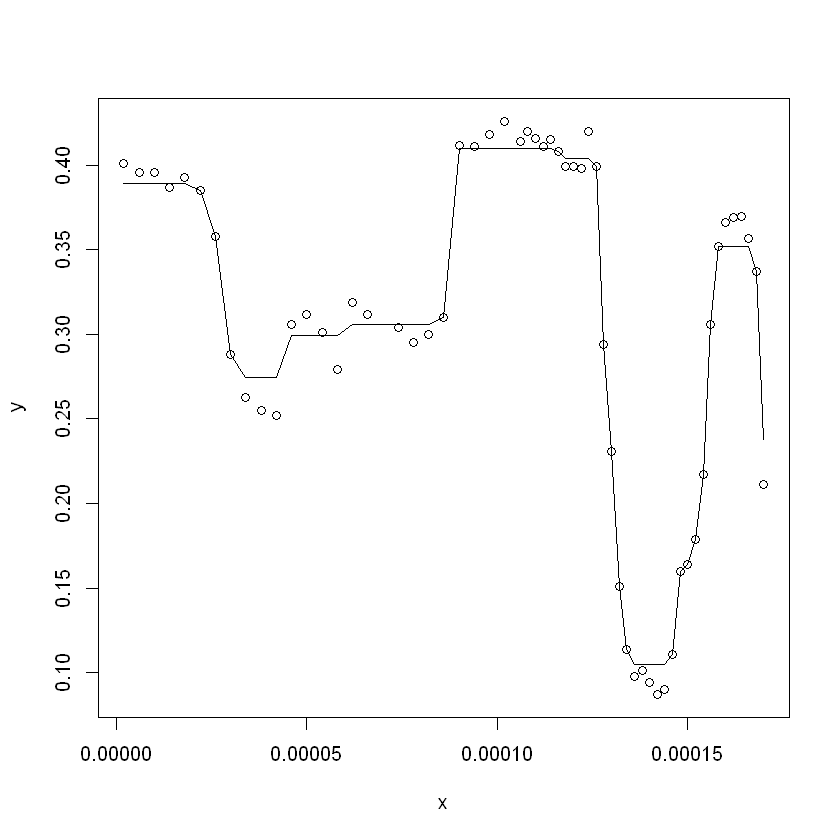

In [60]:
df %>%
    .$Cr2O3 -> y

df %>% 
    .$x -> x

lambda <- 0.05


y %>%
    fusedlasso1d %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        print(cv$se[cv$i.1se])
        y %>%
            fusedlasso1d %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                print("slope center")
                print(getEdgeOfFlat(coef$beta))
                #print(coef$beta)
                print(getSlopeCenter(x,getEdgeOfFlat(coef$beta)))
                print("MSE")
                print(getMSE(coef$beta,y))
                plot(x, y)
                lines(x, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.027
       0.027 
0.0001090931 
[1] "slope center"
 [1]  1  6  8 11 12 15 16 20 22 31 32 35 40 46 52 56
[1] 0.000002 0.000026 0.000044 0.000060 0.000086 0.000117 0.000129 0.000152
[9] 0.000168
[1] "MSE"
[1] 0.01603693


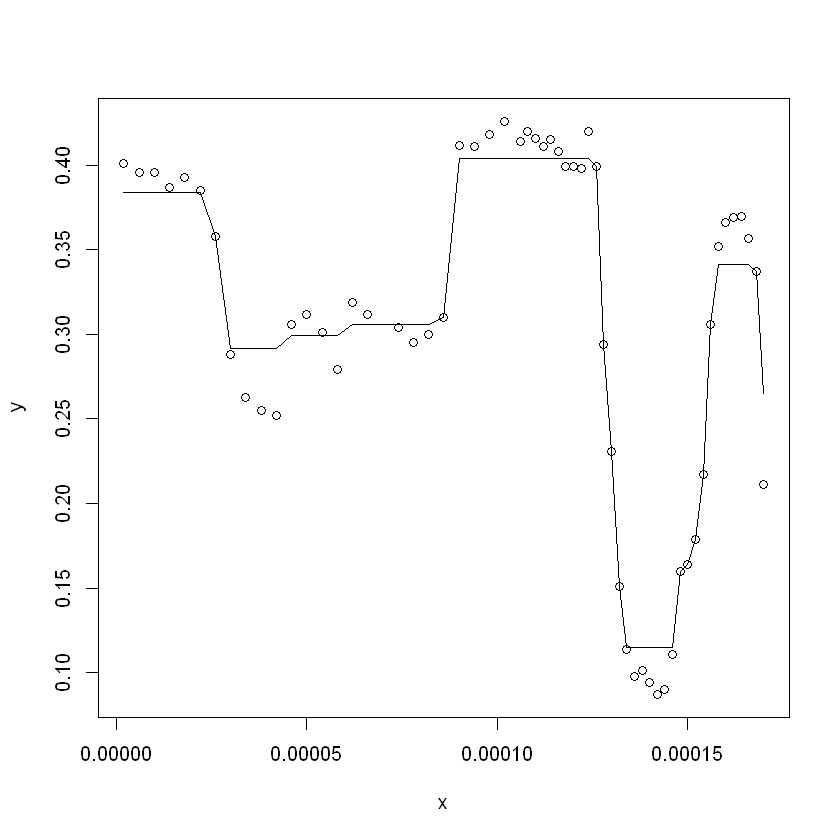

In [3]:
df %>%
    .$Cr2O3 -> y

df %>% 
    .$x -> x

lambda <- 0.05


y %>%
    fusedlasso1d %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        print(cv$se[cv$i.1se])
        y %>%
            fusedlasso1d %>%
            coef(lambda=cv$lambda.1se*2) %>%
            tee(function(coef){
                print("slope center")
                print(getEdgeOfFlat(coef$beta))
                #print(coef$beta)
                print(getSlopeCenter(x,getEdgeOfFlat(coef$beta)))
                print("MSE")
                print(getMSE(coef$beta,y))
                plot(x, y)
                lines(x, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.01075
      0.011 
1.06067e-05 
[1] "slope center"
 [1]  1  6 10 13 15 19 22 23 24 32 35 36 38 42 43 50 51 54 55 56 57
 [1] 0.000002 0.000030 0.000054 0.000084 0.000096 0.000121 0.000128 0.000139
 [9] 0.000155 0.000163 0.000167 0.000169
[1] "MSE"
[1] 0.004765209


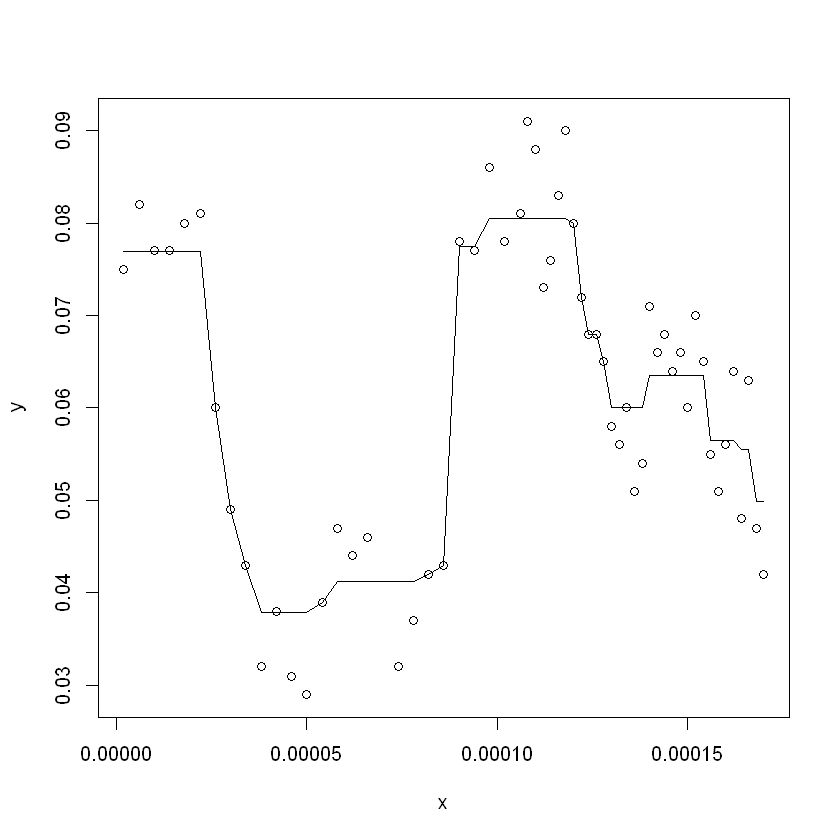

In [62]:
df %>%
    .$NiO -> y

df %>% 
    .$x -> x

lambda <- 0.05


y %>%
    fusedlasso1d %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        print(cv$se[cv$i.1se])
        y %>%
            fusedlasso1d %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                print("slope center")
                print(getEdgeOfFlat(coef$beta))
                #print(coef$beta)
                print(getSlopeCenter(x,getEdgeOfFlat(coef$beta)))
                print("MSE")
                print(getMSE(coef$beta,y))
                plot(x, y)
                lines(x, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.009198811
       0.009 
4.194139e-06 
[1] "slope center"
 [1]  1  4  5  6 10 15 16 19 23 33 40 41 42 45 53 56
[1] 0.000002 0.000016 0.000030 0.000060 0.000086 0.000127 0.000137 0.000152
[9] 0.000168
[1] "MSE"
[1] 0.002937727


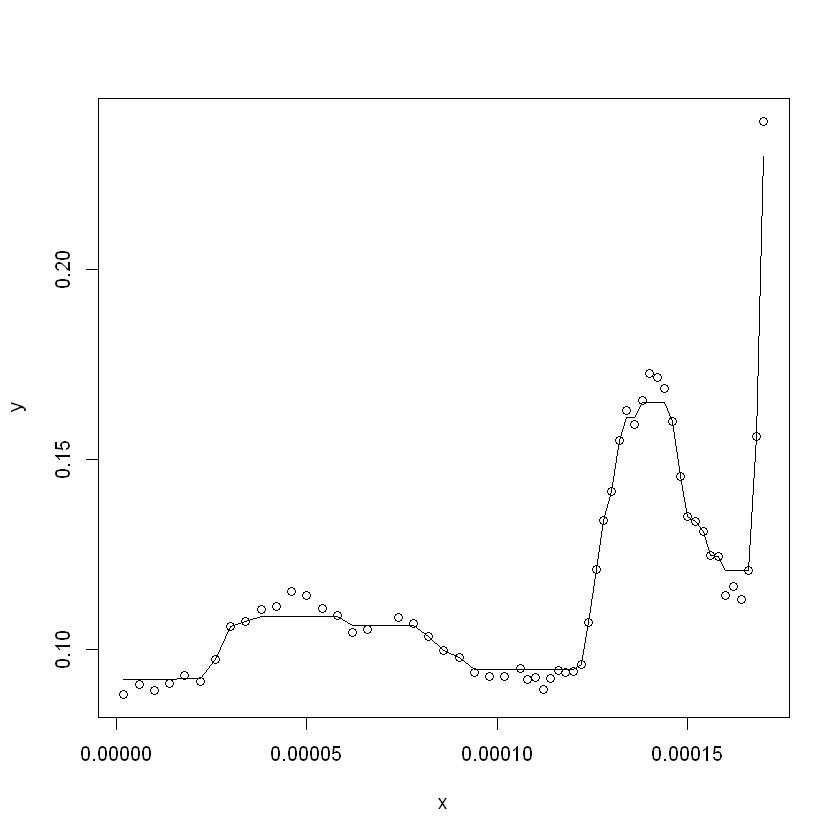

In [61]:
df %>%
    .$Fe_Mg-> y

df %>% 
    .$x -> x

lambda <- 0.05


y %>%
    fusedlasso1d %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        print(cv$se[cv$i.1se])
        y %>%
            fusedlasso1d %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                print("slope center")
                print(getEdgeOfFlat(coef$beta))
                #print(coef$beta)
                print(getSlopeCenter(x,getEdgeOfFlat(coef$beta)))
                print("MSE")
                print(getMSE(coef$beta,y))
                plot(x, y)
                lines(x, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.01606364
       0.016 
0.0001216652 
[1] "MSE"
[1] 0.01143489


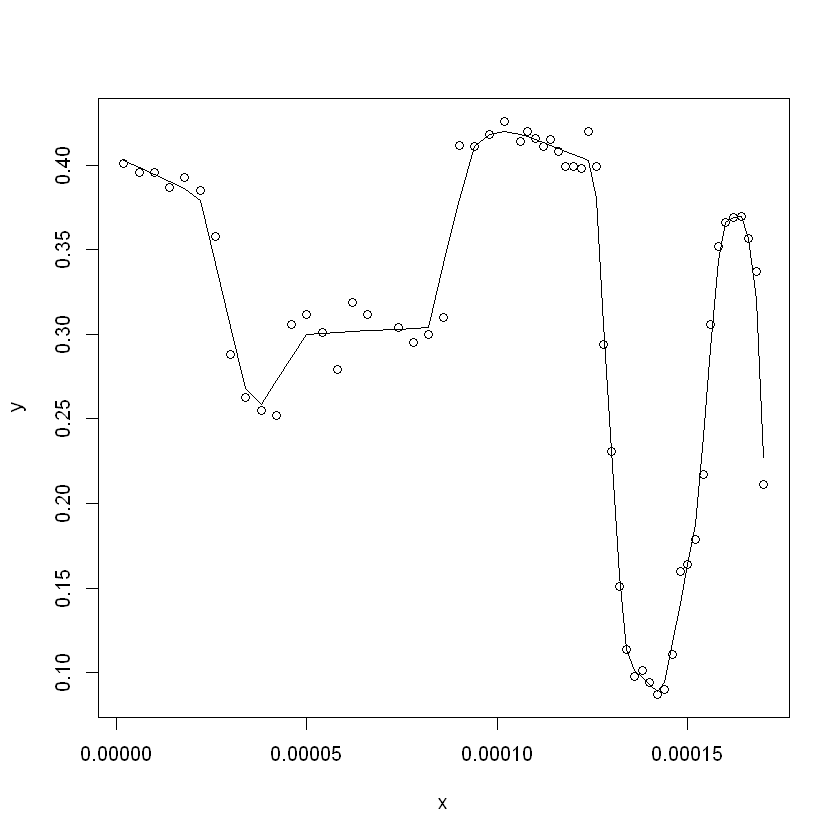

In [30]:
df %>%
    .$Cr2O3 -> y

df %>% 
    .$x -> x

y %>%
    trendfilter(ord=1) %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        print(cv$se[cv$i.1se])
        y %>%
            trendfilter(ord=1) %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                print("MSE")
                print(getMSE(coef$beta,y))
                plot(x, y)
                lines(x, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible


Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.006666667
       0.007 
8.121126e-06 
[1] "MSE"
[1] 0.00504091


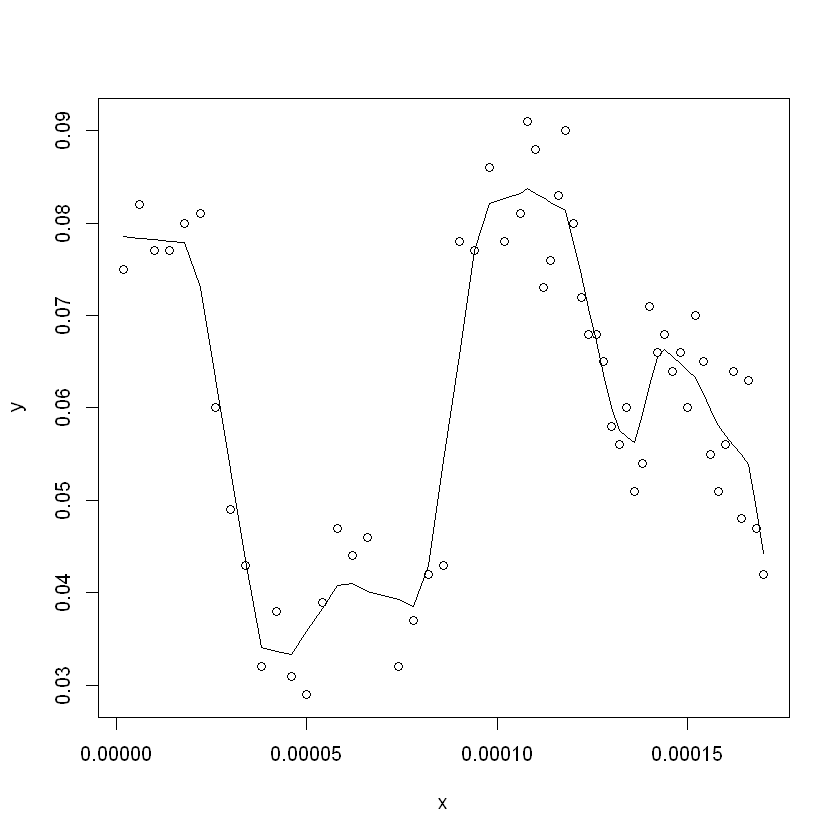

In [63]:
df %>%
    .$NiO -> y

df %>% 
    .$x -> x

y %>%
    trendfilter(ord=1) %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        print(cv$se[cv$i.1se])
        y %>%
            trendfilter(ord=1) %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                print("MSE")
                print(getMSE(coef$beta,y))
                plot(x, y)
                lines(x, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible

Fold 1 ... Fold 2 ... Fold 3 ... Fold 4 ... Fold 5 ... 
[1] 0.009273538
       0.009 
8.710443e-06 
[1] "MSE"
[1] 0.002819423


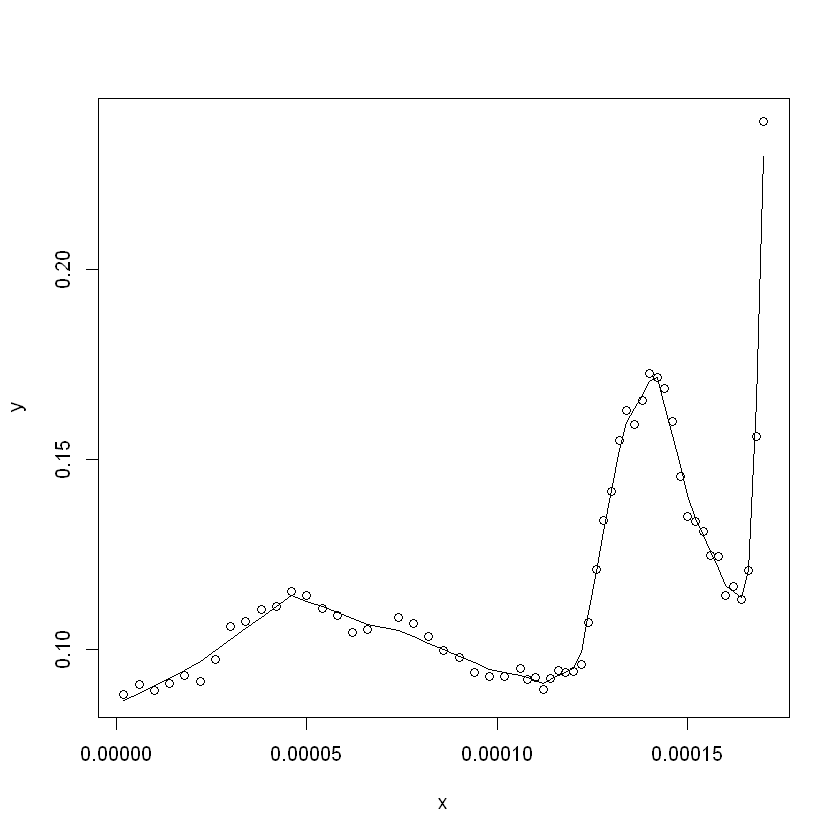

In [25]:
df %>%
    .$Fe_Mg -> y

df %>% 
    .$x -> x

y %>%
    trendfilter(ord=1) %>%
    cv.trendfilter %>%
    tee(function(cv){
        print(cv$lambda.1se)
        print(cv$se[cv$i.1se])
        y %>%
            trendfilter(ord=1) %>%
            coef(lambda=cv$lambda.1se) %>%
            tee(function(coef){
                print("MSE")
                print(getMSE(coef$beta,y))
                plot(x, y)
                lines(x, coef$beta)
            }) %>% invisible
            #plot(,x=radius, lambda=cv$lambda.1se) %>%
            #invisible
    }) %>%
    invisible